In [1]:
import warnings

warnings.filterwarnings('ignore')

### API

### State

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

### Tools setting

In [4]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.prebuilt import ToolNode, tools_condition

web_search = TavilySearchResults(max_results=2)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. chart labels should be written in English.
    This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

tools  = [web_search, python_repl]
tool_node = ToolNode(tools)

### Agent

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

In [6]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return 'end'
    else:
        return 'continue'

In [8]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

workflow.add_node("agent", agent)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tool",
        "end": END
    },
)
workflow.add_edge("tool", "agent")

memory = MemorySaver()

graph = workflow.compile(checkpointer=memory, interrupt_before=["tool"])

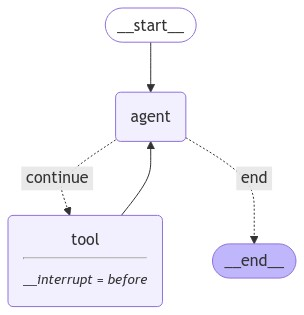

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_input = {"messages": [HumanMessage(content="LLM agent의 연구 및 개발이 어떻게 이루어지고 있는지 표로 나타내줘(현재, 2024년 11월 25일)")]}
thread = {"configurable": {"thread_id": "13"}}

async for chunk in graph.astream(initial_input, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'agent'
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kr1KW12YRJkhLXkDwrhFyTwI', 'function': {'arguments': '{"query":"LLM agent 연구 개발 현황 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 181, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-160319e6-490f-49b3-8bc3-125e2826727a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LLM agent 연구 개발 현황 2024'}, 'id': 'call_kr1KW12YRJkhLXkDwrhFyTwI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 181, 'output_tokens': 27, 'total

In [11]:
async for chunk in graph.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'tool'
{'messages': [ToolMessage(content='[{"url": "https://www.lgresearch.ai/blog/view?seq=484", "content": "ACL 2024, LLM, LLM 신뢰성 평가 ... Reflexion: Language agents with verbal rein- forcement learning. In NeurIPS. [7] Noah Siegel, Oana-Maria Camburu, Nicolas Heess, and Maria Perez-Ortiz. 2024. The Probabilities Also Matter: A More Faithful Metric for Faithfulness of Free-Text Explanations in Large Language Models. In Proceedings of the"}, {"url": "https://openreview.net/group?id=ICLR.cc/2024/Workshop/LLMAgents", "content": "Welcome to the OpenReview homepage for ICLR 2024 Workshop LLMAgents. Toggle navigation OpenReview.net. Login; Open Peer Review. Open Publishing. Open Access. Open Discussion. Open Recommendations. Open Directory. Open API. Open Source."}]', name='tavily_search_results_json', id='9a4cd28d-2cec-4d28-8c0d-3408b4dafcec', tool_call_id='call_kr1KW12YRJkhLXkDwrhFyTwI', artifact={'query': 'LLM agent 연구 개발 현황 2024', 'follow_up_questions': None,

In [12]:
async for chunk in graph.astream(None, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'tool'
{'messages': [ToolMessage(content='[{"url": "https://www.lgresearch.ai/blog/view?seq=473", "content": "BLOG&NEWS RESEARCH BLOG BLOG&NEWS RESEARCH BLOG RECRUIT LOCATION RESEARCH BLOG [1] Wang, Haoxiang, et al. \\"Prometheus 2: An Open Source Language Model Specialized in Evaluating Other Language Models.\\" arXiv preprint arXiv:2405.01535 (2024).[3] Zheng, Lianmin, et al. \\"Jailbreak and Guard Aligned Language Models with Only Few In-context Demonstrations.\\" arXiv preprint arXiv:2310.06387 (2023). \\"Jailbreaking Black Box Large Language Models in Twenty Queries.\\" arXiv preprint arXiv:2310.08419 (2023). \\"Direct Preference Optimization: Your Language Model is Secretly a Reward Model.\\" Advances in Neural Information Processing Systems 36 (2024). \\"Smoothllm: Defending Large Language Models Against Jailbreaking Attacks.\\" arXiv preprint arXiv:2310.03684 (2023)."}, {"url": "https://www.skelterlabs.com/blog/2024-year-of-the-rag", "content": "[무료 

In [21]:
values['messages'][0].content

'다음은 LLM(대형 언어 모델) 에이전트의 연구 및 개발 동향에 대한 표입니다.\n\n| 날짜          | 연구/개발 진행 상황                                                                                                   | 주요 내용 및 기술                                          | 참고 자료                                       |\n|---------------|---------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------|-------------------------------------------------|\n| 2024년 11월 25일 | Reflexion: 언어 에이전트의 언어 강화 학습 연구 발표                                                            | 언어 모델의 신뢰성 평가 및 향상 기술                    | [LG Research](https://www.lgresearch.ai/blog/view?seq=484) |\n| 2024년 11월 25일 | Prometheus 2 공개: 다른 언어 모델을 평가하기 위한 오픈 소스 언어 모델 개발                                     | 언어 모델 간 비교 및 평가 방법론                       | [LG Research](https://www.lgresearch.ai/blog/view?seq=473) |\n| 2024년 11월 25일 | RAG(검색 증강 생성) 기술의 부상 및 연구   